In [1]:
# Imports for data manipulation
import pandas as pd
import numpy as np
import pickle

In [2]:
# Importa for data visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [32]:
# Load the CSV file into a DataFrame
crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')

C:\Users\aarav\AppData\Local\Temp\ipykernel_13872\3131610019.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')


In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def aggregate_crimes_by_zip(crime_data):
    """
    This function aggregates crimes by ZIP code for Phoenix area ZIPs (85001 - 85100).
    """
    # Phoenix + Tempe ZIP code range
    zip_codes = list(range(85001, 85099)) + list(range(85280, 85289))
    
    # Filter for Phoenix ZIP codes
    filtered_crime_data = crime_data[crime_data['ZIP'].isin(zip_codes)]
    
    # Group by ZIP and count crimes
    crime_count_by_zip = filtered_crime_data['ZIP'].value_counts().reset_index()
    crime_count_by_zip.columns = ['ZIP', 'Crime Count']
    
    return crime_count_by_zip

crime_count_by_zip = aggregate_crimes_by_zip(crime_data)

       ZIP  Crime Count
0  85015.0        28032
1  85008.0        26679
2  85051.0        25213
3  85009.0        24759
4  85041.0        23580


In [81]:
#create a function that will look at 'UCR_CRIME_CATEGORY' and give a classfication of crimes based on text entries with "ASSUALT", "THEFT" and "OTHER"
def classify_crime(crime_data):
    """
    This function classifies crimes into categories (ASSAULT, THEFT, OTHER) and returns counts.
    """
    if 'UCR CRIME CATEGORY' not in crime_data.columns:
        raise ValueError("The DataFrame must contain a 'UCR CRIME CATEGORY' column.")
    
    # Create a column for crime classification
    crime_data['Crime Classification'] = 'OTHER'
    
    # Classify crimes
    assault_indices = crime_data[crime_data['UCR CRIME CATEGORY'].str.contains('AGGRAVATED ASSAULT|RAPE|MURDER', case=False)].index
    theft_indices = crime_data[crime_data['UCR CRIME CATEGORY'].str.contains('BURGLARY|LARCENY|MOTOR VEHICLE|ROBBERY', case=False)].index
    other_indices = crime_data[~crime_data.index.isin(assault_indices) & ~crime_data.index.isin(theft_indices)].index
    
    # Assign classifications
    crime_data.loc[assault_indices, 'Crime Classification'] = 'ASSAULT'
    crime_data.loc[theft_indices, 'Crime Classification'] = 'THEFT'
    crime_data.loc[other_indices, 'Crime Classification'] = 'OTHER'
    
    # Return the counts
    return len(assault_indices), len(theft_indices), len(other_indices)

assault_count, theft_count, other_count = classify_crime(crime_data)
print(f"Assault count: {assault_count}", f"Theft count: {theft_count}", f"Other count: {other_count}")

Assault count: 62180 Theft count: 440758 Other count: 56679


In [118]:
def create_features(crime_data):
    """
    This function creates features for the Random Forest model based on the crime data.
    """
    crime_data = classify_crime(crime_data)
    
    # Aggregate crimes by ZIP code
    crime_by_zip = aggregate_crimes_by_zip(crime_data)
    
    # Create feature DataFrame
    features = crime_by_zip.copy()
    
    # Create additional features (e.g., proportion of different crime classifications)
    classification_counts = crime_data.groupby('ZIP')['Crime Classification'].value_counts().unstack(fill_value=0)
    classification_counts.columns = ['ASSAULT', 'THEFT', 'OTHER']
    
    # Merge features
    features = features.merge(classification_counts, on='ZIP', how='left').fillna(0)
    
    return features


In [119]:
def train_crime_classifier(crime_data):
    """
    This function trains a Random Forest classifier on the crime data.
    """
    # Prepare features and target
    features = create_features(crime_data)
    
    # Define the target variable based on 'Crime Count' levels
    # Define bins for crime levels (you can adjust these as needed)
    bins = [0, 10, 50, 100, float('inf')]
    labels = ['LOW', 'MEDIUM', 'HIGH', 'VERY HIGH']
    features['Crime Level'] = pd.cut(features['Crime Count'], bins=bins, labels=labels)

    # Features for the model (excluding 'ZIP' and target)
    X = features.drop(['ZIP', 'Crime Count', 'Crime Level'], axis=1)
    y = features['Crime Level']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    return model


In [120]:
def predict_crime_levels(crime_data, model):
    """
    This function predicts crime levels for each ZIP code using the trained model.
    """
    # Create features from crime data
    features = create_features(crime_data)
    
    # Prepare features for prediction (excluding 'ZIP' and target)
    X = features.drop(['ZIP', 'Crime Count', 'Crime Level'], axis=1)

    # Predict crime levels
    features['Predicted Crime Level'] = model.predict(X)

    return features[['ZIP', 'Predicted Crime Level']]


In [121]:
model = train_crime_classifier(crime_data)


TypeError: tuple indices must be integers or slices, not str

In [101]:
def classify_level_from_counts(crime_counts):
    """
    This function classifies the crime level based on the aggregated crime counts.
    """
    def classify_level(count):
        if count > 150:
            return 'Very High'
        elif 100 < count <= 150:
            return 'High'
        elif 50 <= count <= 100:
            return 'Moderate'
        elif 10 <= count < 50:
            return 'Low'
        else:
            return 'Very Low'
    
    crime_counts['Level'] = crime_counts['Crime Count'].apply(classify_level)
    return crime_counts

# Example Usage
# Assuming crime_data is your initial DataFrame
# 1. Classify crimes
assault_count, theft_count, other_count = classify_crime(crime_data)

# 2. Aggregate crimes by ZIP code
aggregated_crimes = aggregate_crimes_by_zip(crime_data)

# 3. Classify levels based on aggregated crime counts
final_crime_levels = classify_level_from_counts(aggregated_crimes)

# Display the result
final_crime_levels.to_csv('classified_data.csv', index=False)
print("Classified crime data has been saved to classified_data.csv")



Classified crime data has been saved to classified_data.csv


In [111]:
import pandas as pd
from geopy.geocoders import Nominatim
import time
from geopy.exc import GeocoderTimedOut

# Create a geolocator object with a user agent
geolocator = Nominatim(user_agent="Geopy_Library")

def geocode_with_retry(address, attempts=3, timeout=10):
    """
    This function tries to geocode the address multiple times in case of a timeout.
    """
    for i in range(attempts):
        try:
            location = geolocator.geocode(address, timeout=timeout)
            if location:
                return location.latitude, location.longitude
            else:
                return None, None
        except GeocoderTimedOut:
            print(f"Timeout error on attempt {i+1} for address: {address}. Retrying...")
            time.sleep(2)  # Wait 2 seconds before retrying
    return None, None  # Return None after exceeding the number of attempts

def geocode_address(row):
    """
    This function takes a row of data and returns latitude and longitude 
    by geocoding the address using the Nominatim geocoder.
    """
    address = row['100 BLOCK ADDR'].replace("XX", "00")  # Replace XX with 00
    zip_code = row['ZIP']
    full_address = f"{address}, Phoenix, AZ {zip_code}, USA"
    
    # Call the retry-enabled geocoding function
    return pd.Series(geocode_with_retry(full_address))

# Load the data from the CSV file
crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')

# Apply the geocoding function with retries to the DataFrame
crime_data[['Latitude', 'Longitude']] = crime_data.apply(geocode_address, axis=1)

# Display the result
print(crime_data)

# Save the updated DataFrame to a new CSV file
crime_data.to_csv('crime_data_with_coordinates.csv', index=False)


C:\Users\aarav\AppData\Local\Temp\ipykernel_13872\315955869.py:38: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data = pd.read_csv('../data/crime-data_crime-data_crimestat.csv')


KeyboardInterrupt: 

In [88]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import StandardScaler

# def determine_crime_level(crime_count_by_zip, assault_count_by_zip):
#     """
#     Determines the crime level for each ZIP based on crime counts and severity using a Random Forest Classifier.

#     Parameters:
#     - crime_count_by_zip: DataFrame containing 'ZIP' and 'Crime Count' columns.
#     - assault_count_by_zip: Dictionary mapping ZIP to Assault Count.

#     Returns:
#     - DataFrame with a new 'Level' column indicating the crime level.
#     """
#     assault_df = pd.DataFrame(list(assault_count_by_zip.items()), columns=['ZIP', 'Assault Count'])
#     crime_data = crime_count_by_zip.merge(assault_df, on='ZIP', how='left').fillna(0)

#     def classify_level(row):
#         if row['Crime Count'] > 150 or (row['Assault Count'] / row['Crime Count']) > 0.5:
#             return 'Very High'
#         elif 100 < row['Crime Count'] <= 150 or (0.3 < (row['Assault Count'] / row['Crime Count']) <= 0.5):
#             return 'High'
#         elif 50 <= row['Crime Count'] <= 100 or (0.1 <= (row['Assault Count'] / row['Crime Count']) <= 0.3):
#             return 'Moderate'
#         elif 10 <= row['Crime Count'] < 50:
#             return 'Low'
#         elif row['Crime Count'] < 10:  # Explicit check for very low crime areas
#             return 'Very Low'
#         else:  # Catch-all, should not normally hit this point
#             return 'Undefined'  # This helps in identifying any unexpected values

#     crime_data['Level'] = crime_data.apply(classify_level, axis=1)

#     # Features and target variable
#     X = crime_data[['Crime Count', 'Assault Count']]
#     y = crime_data['Level']

#     print("Class distribution before training:\n", y.value_counts())

#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

#     rf_classifier = RandomForestClassifier(random_state=42)

#     param_grid = {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [None, 10, 20, 30],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#     }

#     grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
#                                cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

#     grid_search.fit(X_train, y_train)

#     best_rf_classifier = grid_search.best_estimator_

#     y_pred = best_rf_classifier.predict(X_test)

#     print("Classification Report:\n", classification_report(y_test, y_pred))

#     crime_data['Level'] = best_rf_classifier.predict(X_scaled)

#     return crime_data


In [64]:
import openai

# Function to call Gemini API with a population prompt
def get_population_data(zip_code, api_key):
    # Set up your API key (You can set it from an environment variable for security)
    openai.api_key = api_key

    # The prompt you want to send to the API
    prompt = f"""
    You are a data retrieval assistant. I need the total population for a given U.S. zip code from 2015 to 2023.
    For the zip code {zip_code}, retrieve the population values for each year (2015-2023), and provide both individual year populations and the total sum.

    Please return the information in the following format:

    Input zip code: {zip_code}

    Yearly populations:
    2015: [population]
    2016: [population]
    2017: [population]
    ...
    2023: [population]

    Total population (2015-2023): [total]

    Use the most reliable datasets available (e.g., U.S. Census, government resources).
    """

    # Send the prompt to Gemini
    response = openai.Completion.create(
        model="gemini-1.5-flash-002",  # Or whichever Gemini model you are using
        prompt=prompt,
        max_tokens=300,  # Adjust the length as needed
        n=1,
        stop=None,
        temperature=0.5
    )

    # Get the response from Gemini
    output = response['choices'][0]['text']
    return output

# Input the zip code and API key
zip_code = "85281"  # Change this to your zip code
  # Replace with your Gemini API key

APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


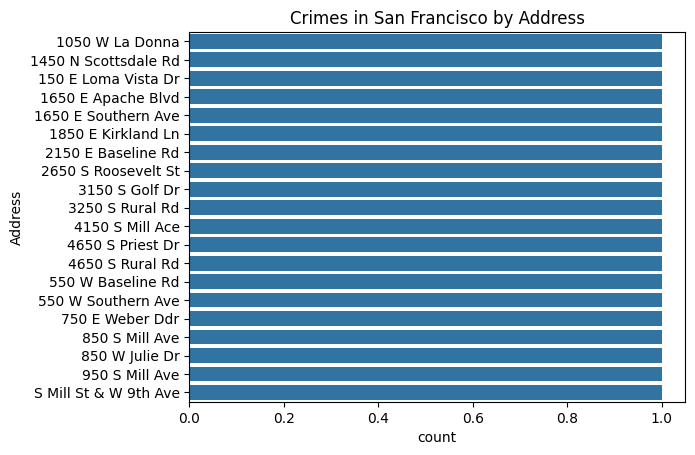

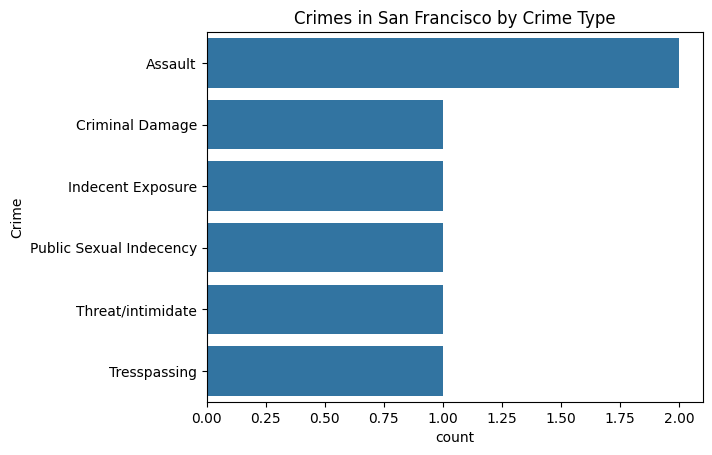

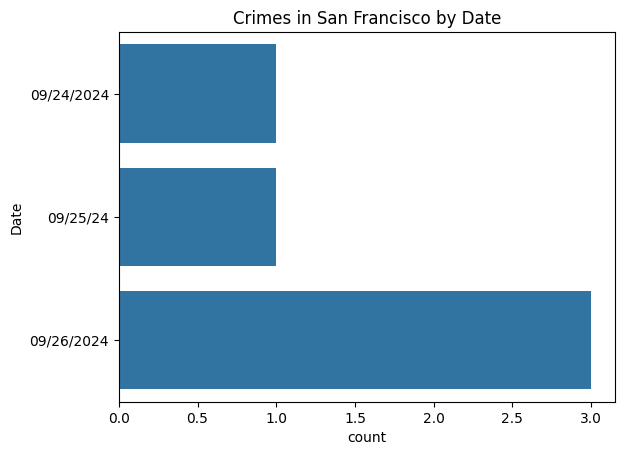

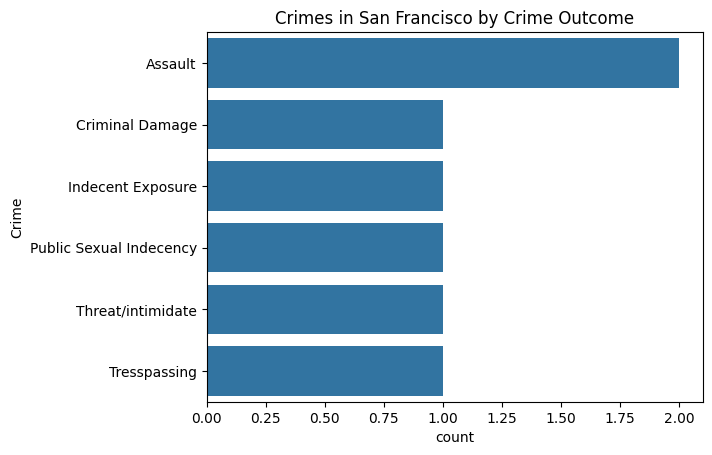

In [31]:
plotCrimeCounts(sfdata, columnsToPlotSF, 'San Francisco')

In [30]:
# Read bosdata
import re
import warnings

bos_file = '../data/crime.csv'
target_type = str  # The desired output type

with warnings.catch_warnings(record=True) as ws:
    warnings.simplefilter("always")

    bosData = pd.read_csv(bos_file, sep=",", header=0, encoding='ISO-8859-1')
    print("Warnings raised:", ws)
    # We have an error on specific columns, try and load them as string
    for w in ws:
        s = str(w.message)
        print("Warning message:", s)
        match = re.search(r"Columns \(([0-9,]+)\) have mixed types\.", s)
        if match:
            columns = match.group(1).split(',') # Get columns as a list
            columns = [int(c) for c in columns]
            print("Applying %s dtype to columns:" % target_type, columns)
            bosData.iloc[:,columns] = bosData.iloc[:,columns].astype(target_type)

Warnings raised: []


In [33]:
# Create histograms on some important metrics for Boston
columnsToPlotBos = { 'Reporting District' : 'DISTRICT', 
                     'Offense Type' : 'OFFENSE_CODE_GROUP',
                     'Year' : 'YEAR', 
                     'Month' : 'MONTH',
                     'Day of the Week' : 'DAY_OF_WEEK'}

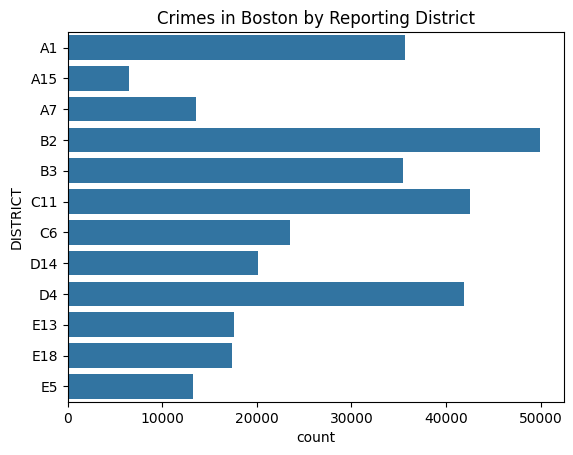

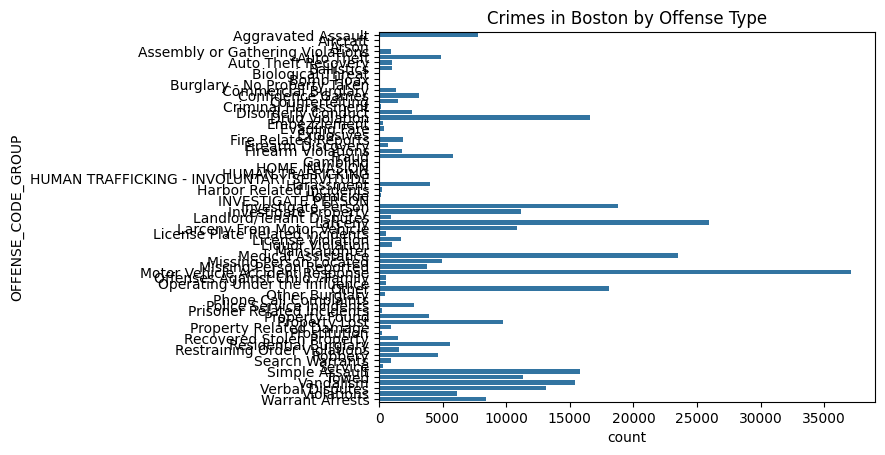

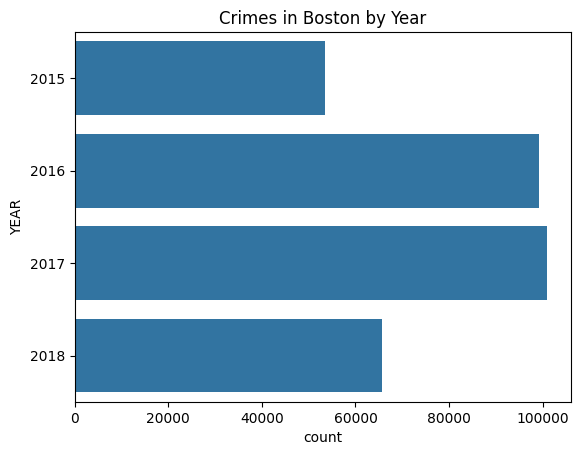

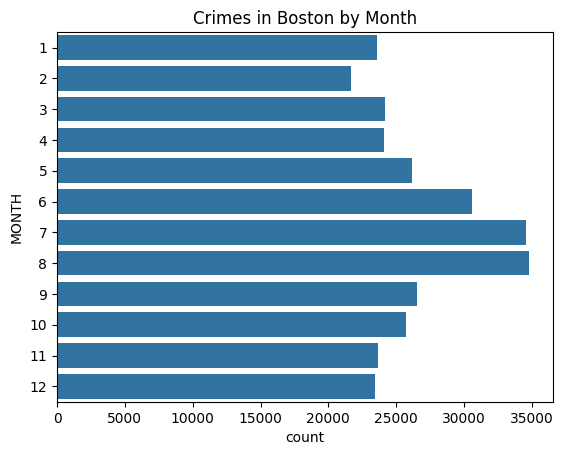

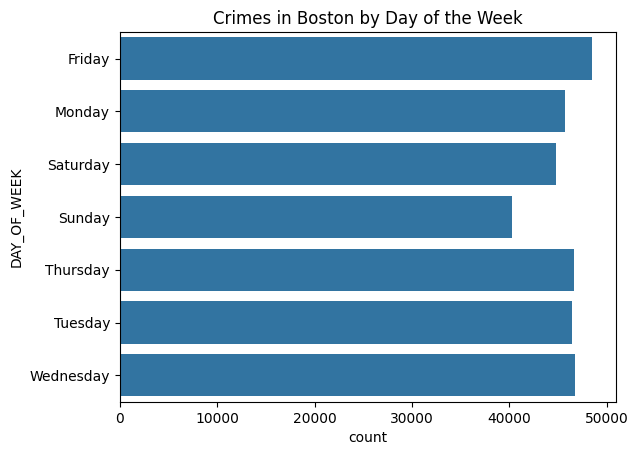

In [34]:
plotCrimeCounts(bosData, columnsToPlotBos, 'Boston')

In [15]:
loadPickle = True

In [16]:
# Convert date to actual date format. This might take a while!
# Note that we should not have to do this once the data
# has been cleaned!
# SKIP IF CLEAN DATA EXISTS
if not loadPickle:
    sfdata.Date = sfdata['Date'].apply(lambda x: pd.to_datetime(x, errors='raise'))
    sfdata.Time = sfdata['Time'].apply(lambda x: pd.to_datetime(x, errors='raise'))

In [17]:
sfpickle_file = '../data/chicago_feats.pkl'

In [18]:
# We only need to do this once, afterwards we should load from the 
# saved location.
# DO NOT RUN IF PICKLED FILE ALREADY EXISTS
if not loadPickle:
    sfclean = cleanColumns(sfdata)
    sfclean = extractDateFeatures(sfclean)
    sfclean.to_pickle(sfpickle_file)

In [22]:
# Load sfclean from pickled location!
sfclean = open(sfpickle_file)
sfclean = pickle.load(sfclean)

TypeError: a bytes-like object is required, not 'str'

In [20]:
# Sort the data by time
sfclean = sfclean.sort_values(by='TimeFeature')

AttributeError: '_io.TextIOWrapper' object has no attribute 'sort_values'

In [22]:
# Save memory by deleting old data
del(sfdata)
# del(sfclean_data)

In [23]:
# Generate some additional histograms
columnsToPlotSF2 = { 'Month' : 'Month',
                    'Day of Month' : 'DoM',
                    'Year' : 'Year',
                   'Hour of Day' : 'ToD' }

In [24]:
plotCrimeCounts(sfclean, columnsToPlotSF2, 'San Franscisco')

In [29]:
histograms(sfclean, 'San Francisco', 'sf_data_analysis')

In [36]:
# Let's generate some heatmaps for both of these data crimes
# Can we overlay these on top of the geographical location???
n = 30
SFByRegion = createPartitions(sfclean, n)

In [39]:
sns.heatmap(createHeatmapData(SFByRegion))
plt.title('Crime Distribution in San Francisco')
plt.show()

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [ ]:
yearByYear(SFByRegion, 'sf_data_analysis', 'San Francisco')

In [ ]:
monthByMonth(SFByRegion, 'sf_data_analysis', 'San Francisco')

In [40]:
# We now process the Boston Data: Again, we pickle the results.
loadBosPickle = True
bos_pickle_file = '../../cs281_data/large_data/bosclean.pk'

In [41]:
# Let's process the boston data
if not loadBosPickle:
    # Clean the columns
    bosData['Latitude'] = bosData['X']
    bosData['Longitude'] = bosData['Y']
    
    # Drop unused columns
    toDrop = ['X', 'Y']
    bosData = bosData.drop(toDrop, axis=1)
    
    # Extract date features
    # day of week
    day = np.array(bosData.DAY_WEEK)
    day[ day == "Sunday"] = 0
    day[ day == "Monday"] = 1
    day[ day == "Tuesday"] = 2
    day[ day == "Wednesday"] = 3
    day[ day == "Thursday"] = 4
    day[ day == "Friday"] = 5
    day[ day == "Saturday"] = 6

    date_time = np.array([x.split() for x in bosData.FROMDATE])
    date = date_time[:,0]
    time = date_time[:,1]
    tod = date_time[:,2]

    # month, day, year
    date = np.array([x.split('/') for x in date])
    month = [int(x) for x in date[:,0]]
    dom = [int(x) for x in date[:,1]]
    year = [int(x) for x in date[:,2]]
    min_year = np.min(year)
    min_month = np.min(month)
    time_feat = np.subtract(year, min_year)*12 + np.subtract(month,min_month)

    # time of day
    time_c = [x.split(':') for x in time]
    time = [int(x[1]) if (y == 'AM' and int(x[0]) == 12) else 60*int(x[0])+int(x[1]) 
            if (y =='AM' and int(x[0]) != 12) or (int(x[0]) == 12 and y == 'PM') else 12*60+60*int(x[0])+int(x[1]) 
            for x,y in zip(time_c, tod)]
    
    # Add them back to the data frame
    bosData['Day'] = day
    del day
    bosData['Month'] = month
    del month
    bosData['Dom'] = dom
    del dom
    bosData['Year'] = year
    del year
    bosData['Time'] = time
    del time
    bosData['TimeFeature'] = time_feat
    del time_feat

In [42]:
# Drop some more unnecessary columns
if not loadBosPickle:
    toDrop = ['COMPNOS', 'NatureCode', 'Location', 'XSTREETNAME', 'STREETNAME']
    toDrop += ['INCIDENT_TYPE_DESCRIPTION', 'MAIN_CRIMECODE', 'REPTDISTRICT']
    toDrop += ['REPORTINGAREA', 'FROMDATE', 'WEAPONTYPE', 'Shooting', 'DOMESTIC']
    toDrop += ['Location']

    bosData = bosData.drop(toDrop, axis=1)
    print "Records before: {}".format(len(bosData))
    bosData = bosData.dropna(axis=0)
    print "Records after: {}".format(len(bosData))

In [43]:
# Lets's save the data
if not loadBosPickle:
    bosData.to_pickle(bos_pickle_file)
    del(bosData)

In [44]:
# Let's load the data
with open(bos_pickle_file) as bosclean_file:
    bosclean = pickle.load(bosclean_file)

In [45]:
histograms(bosclean, 'Boston', 'boston_data_analysis')

In [46]:
# Let's generate some heatmaps on the boston crime data
# Can we overlay these over a boston map?
n = 30
regionedData = createSimplePartitions(bosclean, n)

In [14]:
# Let's do a single large heatmap
sns.heatmap(createHeatmapData(regionedData, n))
plt.title('Crime Distribution in Boston')
plt.show()

NameError: name 'regionedData' is not defined

In [ ]:
yearByYear(regionedData, 'boston_data_analysis', 'Boston')

In [ ]:
monthByMonth(regionedData, 'boston_data_analysis', 'Boston')

In [48]:
# Read in the Chicago data set
import re
import warnings

years = 2000 + np.linspace(1,15, 15)
buckets = np.zeros(1)
target_type = str  # The desired output type

chicagoData = pd.DataFrame()
for year in years:

    data_file = '../../cs281_data/large_data/chicago/%d.0.csv' % year    
    with warnings.catch_warnings(record=True) as ws:
        warnings.simplefilter("always")

        data = pd.read_csv(data_file, sep=",", header=None)
        print("Warnings raised:", ws)
        # We have an error on specific columns, try and load them as string
        for w in ws:
            s = str(w.message)
            print("Warning message:", s)
            match = re.search(r"Columns \(([0-9,]+)\) have mixed types\.", s)
            if match:
                columns = match.group(1).split(',') # Get columns as a list
                columns = [int(c) for c in columns]
                print("Applying %s dtype to columns:" % target_type, columns)
                data.iloc[:,columns] = data.iloc[:,columns].astype(target_type)
        
    chicagoData = chicagoData.append(data,ignore_index=True)
    print len(chicagoData)

('Warnings raised:', [])
485710
('Warnings raised:', [])
972433
('Warnings raised:', [])
1448320
('Warnings raised:', [])
1917629
('Warnings raised:', [])
2371247
('Warnings raised:', [])
2819223
('Warnings raised:', [])
3256088
('Warnings raised:', [])
3682969
('Warnings raised:', [])
4074628
('Warnings raised:', [])
4444648
('Warnings raised:', [])
4795983
('Warnings raised:', [])
5131475
('Warnings raised:', [])
5437860
('Warnings raised:', [])
5711613
('Warnings raised:', [])
5939364


In [49]:
# Extract Features
chicagoData.columns = ['Date', 'Latitude', 'Longitude']
pickledChicago = True
chicago_pickle_file = '../../cs281_data/large_data/chicago.pkl'
if not pickledChicago:
    
    date_time = np.array([x.split() for x in chicagoData.Date])
    date = date_time[:,0]
    time = date_time[:,1]
    tod = date_time[:,2]

    # month, day, year
    date = np.array([x.split('/') for x in date])
    month = [int(x) for x in date[:,0]]
    dom = [int(x) for x in date[:,1]]
    year = [int(x) for x in date[:,2]]
    min_year = np.min(year)
    min_month = np.min(month)
    time_feat = np.subtract(year, min_year)*12 + np.subtract(month,min_month)
    
    time_c = [x.split(':') for x in time]
    time = [int(x[1]) if (y == 'AM' and int(x[0]) == 12) else 60*int(x[0])+int(x[1]) 
            if (y =='AM' and int(x[0]) != 12) or (int(x[0]) == 12 and y == 'PM') else 12*60+60*int(x[0])+int(x[1]) 
            for x,y in zip(time_c, tod)]
    
    chicagoData['Month'] = month
    del month
    chicagoData['DoM'] = dom
    del dom
    chicagoData['Year'] = year
    del year
    chicagoData['ToD'] = tod
    del tod
    chicagoData['Time'] = time
    del time
    chicagoData['TimeFeature'] = time_feat
    del time_feat
    
    # Sort the results
    chicagoData = chicagoData.sort_values(by='TimeFeature')
    
    chicagoData = chicagoData.dropna()
    
    # Save the results to a pickle file
    chicagoData.to_pickle(chicago_pickle_file)
    print "Saved to Pickle File"

In [75]:
# Let's load the data 
with open(chicago_pickle_file) as f:
    %time
    chicagoClean = pickle.load(f)
del chicagoData

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


In [51]:
# Create heatmaps and histograms if possible
columnsToPlotChicago = { 'Year' : 'Year', 
                         'Month' : 'Month',
                         'Day of Month' : 'DoM',
                         'Hour of Day' : 'ToD'}
plotCrimeCounts(chicagoClean, columnsToPlotChicago, 'Chicago')

In [52]:
# Make histograms of the crime
histograms(chicagoClean, 'Chicago', 'chicago_data_analysis')

In [92]:
# Partition into n = 30 
n = 30
%time
chicagoPartitions = createSimplePartitions(chicagoClean, n)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


In [93]:
# Heatmap of the entire Chicago region!
%time
sns.heatmap(createHeatmapData(chicagoPartitions, n))
plt.title('Crime Distribution in Chicago')
plt.show()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15 µs


In [94]:
%%timeit
yearByYear(chicagoPartitions, 'chicago_data_analysis', 'Chicago')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [95]:
%%timeit
monthByMonth(chicagoPartitions, 'chicago_data_analysis', 'Chicago')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


In [ ]:
'''
THE BELOW HAS BEEN MOVED TO BASELINES.ipython
'''
# Calculate averages for each region based on the training set
# Last year
last_year = sfclean.Year.max()
training = sfclean[sfclean.Year != last_year]
test = sfclean[sfclean.Year == last_year]

# Partition the data
averageTrainingData = createPartitions(training, 10)

In [ ]:
years = averageTrainingData.Year.unique()
months = averageTrainingData.Month.unique()
regions = averageTrainingData.Region.unique()

# Calculate how many months of data we have
nmonths = 0
for year in years:
    nmonths += len(averageTrainingData[averageTrainingData.Year == year].Month.unique())

In [ ]:
nmonths

In [ ]:
# Now calculat ethe predictions!
predictions = {}
for region in regions:
    data = partitionedData[partitionedData.Region == region]
    crimes = len(data)
    predictions[region] = crimes / float(nmonths)

In [ ]:
# Now calculate the rmse
testAverage = createPartitions(test, 10)

In [ ]:
# Let's create a dictionary with the counts for region,month,year
from collections import defaultdict
crimeCounts = defaultdict(int)
for i, row in testAverage.iterrows():
    crimeCounts[(row.Region, row.Year, row.Month)] += 1

In [ ]:
# Now calculate the RMSE of this function:
error = []
for region in testAverage.Region.unique():
    data = testAverage[testAverage.Region == region]
    for year in data.Year.unique():
        data2 = data[data.Year == year]
        for month in data2.Month.unique():
            try:
                # print crimeCounts[(region, year, month)]
                # print predictions[region]
                error.append(crimeCounts[(region, year, month)] - 
                         predictions[region])
            except KeyError:
                print region

error = np.array(error)
rmse = np.sqrt(np.sum(error ** 2) / len(error))

In [ ]:
rmse

In [ ]:
np.std(crimeCounts.values())

In [ ]:
np.max(crimeCounts.values())